In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn import tree


## Data Acquisition
##### Flat Acquisition using csv files

In [46]:
movies = pd.read_csv('./data/movies.csv')
# genome_scores = pd.read_csv('./data/genome-scores.csv')
# genome_tags = pd.read_csv('./data/genome-tags.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')

In [47]:
# print the first 5 rows of the movies, ratings, and tags dataframes
display(movies.head())
display(ratings.head())
display(tags.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [48]:
""" # show scatter plot of rating
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(y='rating', x='movieId', data=ratings, ax=ax)
plt.show() """

" # show scatter plot of rating\nfig, ax = plt.subplots(figsize=(5, 5))\nsns.scatterplot(y='rating', x='movieId', data=ratings, ax=ax)\nplt.show() "

In [49]:
""" # show scatter plot of rating
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(y='timestamp', x='movieId', data=ratings, ax=ax)
plt.show() """

" # show scatter plot of rating\nfig, ax = plt.subplots(figsize=(5, 5))\nsns.scatterplot(y='timestamp', x='movieId', data=ratings, ax=ax)\nplt.show() "

In [50]:
""" # show scatter plot of rating
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(y='timestamp', x='movieId', data=tags, ax=ax)
plt.show() """

" # show scatter plot of rating\nfig, ax = plt.subplots(figsize=(5, 5))\nsns.scatterplot(y='timestamp', x='movieId', data=tags, ax=ax)\nplt.show() "

### Data Wrangling

In [51]:
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Merge dei dataset movies e ratings
# rimuove i film che non hanno rating
movies_ratings = pd.merge(movies, grouped_ratings, on='movieId')

# mantiene i duplicati, per rimuoverli usare .apply[set, list]
# tags.groupby('movieId')['tag'].apply(set)
new_tags = tags.groupby('movieId')['tag'].apply(set).apply(list)

df = pd.merge(movies_ratings, new_tags, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,"[rescue, villian hurts toys, comedy, computer ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,"[animals, childish, childhood recaptured, jung..."
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,"[old man, Howard Deutch, moldy, sequel fever, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,"[chick flick, divorce, revenge, based on novel..."
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,"[Touching, confidence, aging, contraception, p..."


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning
The following results show that there are no NaN values in the dataset.

In [52]:
# print number of rows
print('Number of rows: ', df.shape[0])

# drop rows with missing values
df = df.dropna()

# print number of rows after dropping missing values
print('Number of rows after dropping missing values: ', df.shape[0])


Number of rows:  41875
Number of rows after dropping missing values:  41875


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [53]:
# one hot encoding for genres
# print every category in movies dataset
categories = set()
for s in df['genres'].str.split('|').values:
    categories = categories.union(set(s))

# add columns for each category
for category in categories:
    df[category] = df['genres'].str.contains(category).astype(int)

# delete genres column
df = df.drop(columns=['genres'])

display(df.head())

/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_7962/4060750238.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[category] = df['genres'].str.contains(category).astype(int)


,movieId,title,mean_rating,rating_count,mean_timestamp,tag,Mystery,War,Action,Musical,...,Crime,Fantasy,IMAX,Documentary,Children,Comedy,Animation,Romance,Adventure,Sci-Fi
0,1,Toy Story (1995),3.893708,57309,1153152210,"[rescue, villian hurts toys, comedy, computer ...",0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
1,2,Jumanji (1995),3.251527,24228,1122310117,"[animals, childish, childhood recaptured, jung...",0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,"[old man, Howard Deutch, moldy, sequel fever, ...",0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,"[chick flick, divorce, revenge, based on novel...",0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,"[Touching, confidence, aging, contraception, p...",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset (as expected after merge operation).

In [54]:
df_preprocessed = df.copy()

# drop tag column TODO: find a way to use tag
df_preprocessed = df_preprocessed.drop(columns=['tag'])

# print number of rows
print('Number of rows: ', df_preprocessed.shape[0])

# drop duplicated rows
df_preprocessed = df_preprocessed.drop_duplicates()

# print number of rows after dropping missing values
print('Number of rows after dropping duplicated rows: ', df_preprocessed.shape[0])


Number of rows:  41875
Number of rows after dropping duplicated rows:  41875


## Data Visualization

In [55]:
""" # rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings)
plt.show()

sns.boxplot(x='rating', data=ratings)
plt.show() """

" # rating distribution from ratings.csv\nsns.countplot(x='rating', data=ratings)\nplt.show()\n\nsns.boxplot(x='rating', data=ratings)\nplt.show() "

Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

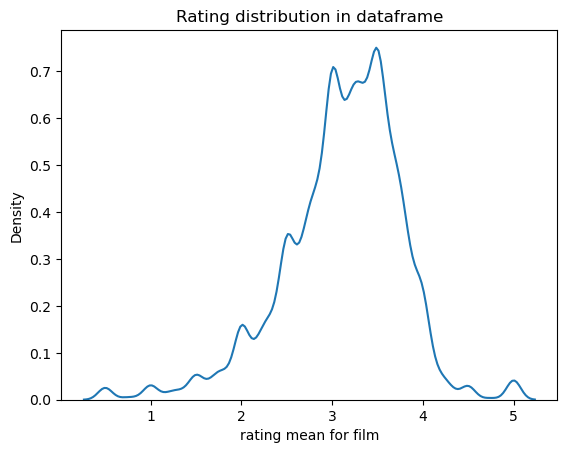

In [56]:
# rating distribution from df
sns.kdeplot(df['mean_rating'])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()

Observing the distribution of all attributes for every file.

This is useful to show data trends, to reveal outliers and leverage points, to provide hints about modeling techniques to apply.


In [57]:
""" # print distribution for ratings
fig, axs = plt.subplots(3)
sns.kdeplot(ratings['timestamp'], ax=axs[0], color='r', label='timestamp')
sns.kdeplot(ratings['rating'], ax=axs[1], color='b', label='rating')
sns.kdeplot(ratings['movieId'], ax=axs[2], color='g', label='movieId')

axs[0].set_xlabel('timestamp')
axs[1].set_xlabel('rating')
axs[2].set_xlabel('movieId')
plt.show() """

" # print distribution for ratings\nfig, axs = plt.subplots(3)\nsns.kdeplot(ratings['timestamp'], ax=axs[0], color='r', label='timestamp')\nsns.kdeplot(ratings['rating'], ax=axs[1], color='b', label='rating')\nsns.kdeplot(ratings['movieId'], ax=axs[2], color='g', label='movieId')\n\naxs[0].set_xlabel('timestamp')\naxs[1].set_xlabel('rating')\naxs[2].set_xlabel('movieId')\nplt.show() "

In [58]:
# Scatter plot matrix
# Completamente inutile
# sns.pairplot(ratings)
# plt.show()

In [59]:
""" movies_to_show = 5
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")
    

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

fig.suptitle('Rating evolution for the 5 most rated movies')
plt.show() """

' movies_to_show = 5\nfig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))\n\nmost_rated_movies = ratings.groupby(\'movieId\').count().sort_values(\'rating\', ascending=False).head(movies_to_show).index\n\nto_line_plot = []\nfor i in range(movies_to_show):\n    tmp = ratings.where(ratings[\'movieId\'] == most_rated_movies[i]).dropna()\n    tmp[\'date\'] = pd.to_datetime(tmp[\'timestamp\'], unit=\'s\')\n    \n    # Computing the mean for each month\n    tmp = tmp.resample("M", on=\'date\').mean()[[\'movieId\', \'rating\']].dropna()\n    to_line_plot.append(tmp)\n    movie_title = movies.where(movies[\'movieId\'] == most_rated_movies[i]).dropna()[\'title\'].values[0]\n    axs[i].set_title("Movie: \'" + movie_title + "\'")\n    \n\nfor i in range(movies_to_show):\n    sns.lineplot(x=\'date\', y=\'rating\', ax=axs[i], data=to_line_plot[i])\n\nfig.suptitle(\'Rating evolution for the 5 most rated movies\')\nplt.show() '

In [60]:
""" # Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

# most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index
high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

# Print the titles of the movies
plt.show() """

' # Same as above cell but the 3 movies with the highest standard deviation\nmovies_to_show = 3\nfig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))\n\n# Take movies with at least 1000 ratings\nhigh_std_movies = ratings.where(\n    ratings[\'movieId\']\n    .isin(ratings.groupby(\'movieId\')\n          .count()\n          .where(ratings.groupby(\'movieId\').count()[\'rating\'] > 1000)\n          .dropna().index)\n    ).dropna()\n\n# most_rated_movies = ratings.groupby(\'movieId\').count().sort_values(\'rating\', ascending=False).head(movies_to_show).index\nhigh_std_movies = high_std_movies.groupby(\'movieId\').std().sort_values(\'rating\', ascending=False).head(movies_to_show).index\n\nto_line_plot = []\nfor i in range(movies_to_show):\n    tmp = ratings.where(ratings[\'movieId\'] == high_std_movies[i]).dropna()\n    tmp[\'date\'] = pd.to_datetime(tmp[\'timestamp\'], unit=\'s\')\n    \n    # Computing the mean for each month\n    tmp = tmp.resample("M", 

Plot density for every attribute of dataset

Number of movies with rating_count < 50:  28848
Number of all movies:  41875


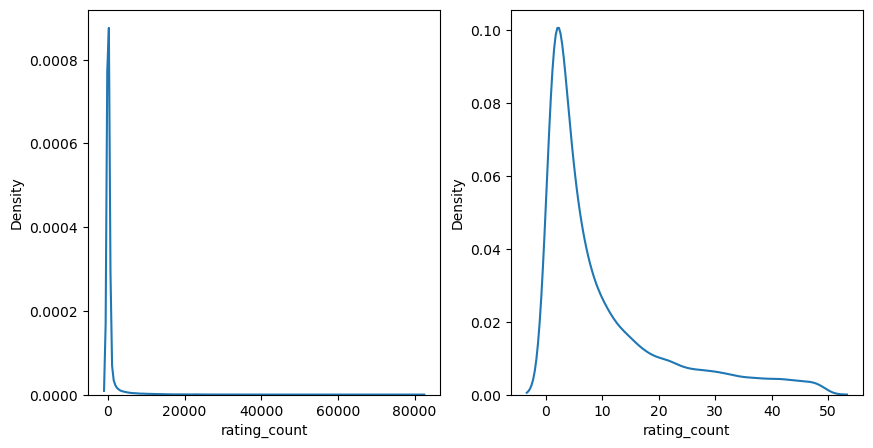

In [61]:
# density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0])

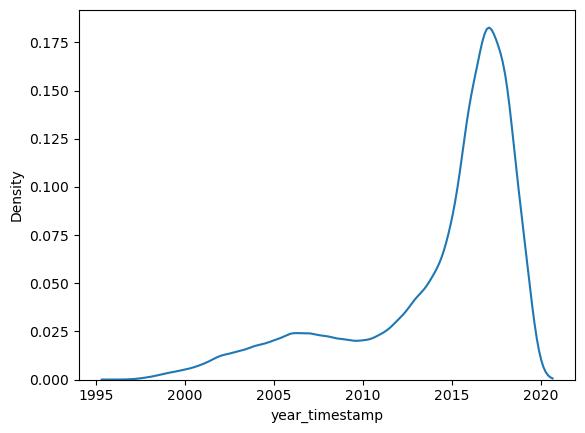

In [62]:
# density plot for rating year

# convert timestamp to year
df['year_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s').dt.year

# delete mean_timestamp column to avoid redundancy - TODO check if it is better to keep it
df = df.drop(columns=['mean_timestamp'])

sns.kdeplot(df['year_timestamp'])
plt.show()

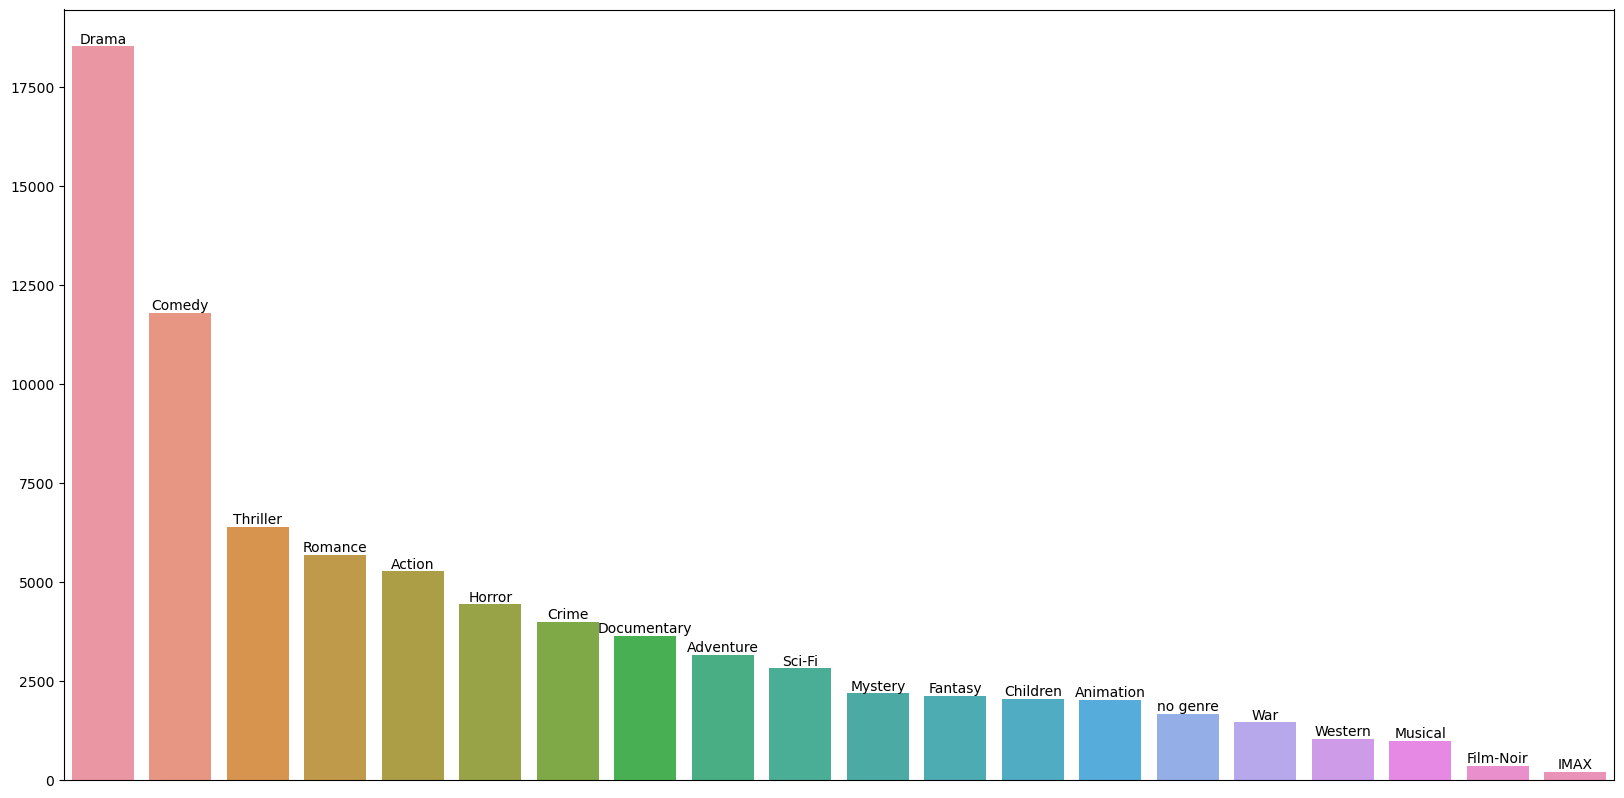

List of attributes:  ['movieId', 'title', 'mean_rating', 'rating_count', 'tag', 'Mystery', 'War', 'Action', 'Musical', 'Drama', 'Film-Noir', 'Thriller', 'Western', 'Horror', 'Crime', 'Fantasy', 'IMAX', 'Documentary', 'Children', 'Comedy', 'Animation', 'Romance', 'Adventure', 'Sci-Fi', 'year_timestamp']


In [63]:
# plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    if category == '(no genres listed)':
        cat_dict['no genre'] = df[category].sum()
    else:
        cat_dict[category] = df[category].sum()

# order the dictionary by value in descending order
cat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
plt.xticks([])
plt.show()

# remove column (no genres listed)
df = df.drop(columns=['(no genres listed)'])

print('List of attributes: ', list(df.columns))


In [64]:
# count the number of rows containing 1 for Film-Noir and IMAX
print('Number of Film-Noir movies: ', df['Film-Noir'].sum())
print('Number of IMAX movies: ', df['IMAX'].sum())


Number of Film-Noir movies:  343
Number of IMAX movies:  194


In [65]:
# compute the ratio of mismatches for each category

# count the number of rows
total_rows = df.shape[0]

mismatches = {}
# remove (no genres listed) from list categories
cat = list(categories)
cat.remove('(no genres listed)')

for category1 in cat:
    for category2 in cat:
        if category1 != category2:
            # count the number of rows where category1 and category2 are both 1
            count = df.where((df[category1] == 1) & (df[category2] == 1)).count()[0]
            if count > 0:
                # if there are rows where category1 and category2 are both 1, add the ratio to the dictionary
                mismatches[category1 + ' - ' + category2] = (total_rows - count) / total_rows

# order the dictionary by value in descending order and print it
mismatches = {k: v for k, v in sorted(mismatches.items(), key=lambda item: item[1], reverse=False)}
display('Mismatches: ', mismatches)


'Mismatches: '

{'Drama - Romance': 0.9170865671641791,
 'Romance - Drama': 0.9170865671641791,
 'Drama - Comedy': 0.9200716417910447,
 'Comedy - Drama': 0.9200716417910447,
 'Drama - Thriller': 0.9361910447761194,
 'Thriller - Drama': 0.9361910447761194,
 'Comedy - Romance': 0.9395582089552239,
 'Romance - Comedy': 0.9395582089552239,
 'Drama - Crime': 0.9449791044776119,
 'Crime - Drama': 0.9449791044776119,
 'Action - Drama': 0.9589253731343284,
 'Drama - Action': 0.9589253731343284,
 'Thriller - Horror': 0.9604059701492538,
 'Horror - Thriller': 0.9604059701492538,
 'Action - Thriller': 0.960620895522388,
 'Thriller - Action': 0.960620895522388,
 'Thriller - Crime': 0.9610507462686567,
 'Crime - Thriller': 0.9610507462686567,
 'Action - Adventure': 0.969265671641791,
 'Adventure - Action': 0.969265671641791,
 'Mystery - Thriller': 0.9726567164179104,
 'Thriller - Mystery': 0.9726567164179104,
 'War - Drama': 0.9746865671641791,
 'Drama - War': 0.9746865671641791,
 'Action - Crime': 0.9755223880597

In [66]:
from scipy.spatial.distance import pdist
# compute the distance matrix for categories
display(df.head())
categories_df = df[df.drop(columns=['movieId', 'title', 'mean_rating', 'rating_count', 'tag', 'year_timestamp']).columns]
display(categories_df.head())

dist_matrix = pdist(categories_df, 'cosine')



,movieId,title,mean_rating,rating_count,tag,Mystery,War,Action,Musical,Drama,...,Fantasy,IMAX,Documentary,Children,Comedy,Animation,Romance,Adventure,Sci-Fi,year_timestamp
0,1,Toy Story (1995),3.893708,57309,"[rescue, villian hurts toys, comedy, computer ...",0,0,0,0,0,...,1,0,0,1,1,1,0,1,0,2006
1,2,Jumanji (1995),3.251527,24228,"[animals, childish, childhood recaptured, jung...",0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,2005
2,3,Grumpier Old Men (1995),3.142028,11804,"[old man, Howard Deutch, moldy, sequel fever, ...",0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2001
3,4,Waiting to Exhale (1995),2.853547,2523,"[chick flick, divorce, revenge, based on novel...",0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1999
4,5,Father of the Bride Part II (1995),3.058434,11714,"[Touching, confidence, aging, contraception, p...",0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2001


,Mystery,War,Action,Musical,Drama,Film-Noir,Thriller,Western,Horror,Crime,Fantasy,IMAX,Documentary,Children,Comedy,Animation,Romance,Adventure,Sci-Fi
0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [44]:
""" from scipy.spatial.distance import squareform

# Create a pandas DataFrame to represent the distance matrix
df_dist = pd.DataFrame(squareform(dist_matrix), columns=np.arange(categories_df.shape[0]), index=np.arange(categories_df.shape[0]))

# Print the DataFrame with observation labels
obs_labels = ['Obs{}'.format(i) for i in range(categories_df.shape[0])]
df_dist.index = obs_labels
df_dist.columns = obs_labels
display(df_dist.head())

# show only rows with at least two columns with value 0
mask = (df_dist == 0).sum(axis=1) >= 2
result = df_dist.loc[mask].dropna(axis=1)
display(result.head())

# print(result[0:1].where(result[0:1] == 0).dropna(axis=1))

print('Number of rows with at least two columns with value 0: ', result.shape[0], ' out of ', df_dist.shape[0]) """

,Obs0,Obs1,Obs2,Obs3,Obs4,Obs5,Obs6,Obs7,Obs8,Obs9,...,Obs41865,Obs41866,Obs41867,Obs41868,Obs41869,Obs41870,Obs41871,Obs41872,Obs41873,Obs41874
Obs0,0.000000,0.225403,0.683772,0.741801,0.552786,1.0,6.837722e-01,0.367544,1.0,0.741801,...,1.000000,1.0,0.552786,1.0,6.837722e-01,0.552786,1.0,0.367544,NaN,NaN
Obs1,0.225403,0.000000,1.000000,1.000000,1.000000,1.0,1.000000e+00,0.183503,1.0,0.666667,...,1.000000,1.0,1.000000,1.0,1.000000e+00,0.422650,1.0,1.000000,NaN,NaN
Obs2,0.683772,1.000000,0.000000,0.183503,0.292893,1.0,2.220446e-16,1.000000,1.0,1.000000,...,1.000000,1.0,0.292893,1.0,2.220446e-16,1.000000,1.0,0.500000,NaN,NaN
Obs3,0.741801,1.000000,0.183503,0.000000,0.422650,1.0,1.835034e-01,1.000000,1.0,1.000000,...,0.591752,1.0,0.422650,1.0,1.835034e-01,1.000000,1.0,0.591752,NaN,NaN
Obs4,0.552786,1.000000,0.292893,0.422650,0.000000,1.0,2.928932e-01,1.000000,1.0,1.000000,...,1.000000,1.0,0.000000,1.0,2.928932e-01,1.000000,1.0,0.292893,NaN,NaN


,Obs0,Obs1,Obs2,Obs3,Obs4,Obs5,Obs6,Obs7,Obs8,Obs9,...,Obs41863,Obs41864,Obs41865,Obs41866,Obs41867,Obs41868,Obs41869,Obs41870,Obs41871,Obs41872
Obs1,0.225403,0.0,1.000000,1.00000,1.00000,1.00000,1.000000,0.183503,1.00000,0.666667,...,1.0,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,0.42265,1.0,1.000000
Obs3,0.741801,1.0,0.183503,0.00000,0.42265,1.00000,0.183503,1.000000,1.00000,1.000000,...,1.0,0.666667,0.591752,1.0,0.42265,1.000000,0.183503,1.00000,1.0,0.591752
Obs4,0.552786,1.0,0.292893,0.42265,0.00000,1.00000,0.292893,1.000000,1.00000,1.000000,...,1.0,1.000000,1.000000,1.0,0.00000,1.000000,0.292893,1.00000,1.0,0.292893
Obs5,1.000000,1.0,1.000000,1.00000,1.00000,0.00000,1.000000,1.000000,0.42265,0.333333,...,1.0,0.666667,1.000000,1.0,1.00000,0.183503,1.000000,1.00000,1.0,1.000000
Obs8,1.000000,1.0,1.000000,1.00000,1.00000,0.42265,1.000000,1.000000,0.00000,0.422650,...,1.0,0.422650,1.000000,1.0,1.00000,0.292893,1.000000,1.00000,1.0,1.000000


Number of rows with at least two columns with value 0:  26153  out of  41875


## Data Preprocessing

In [ ]:

# from title extract year
df['year'] = df['title'].str.extract('(\(\d{4}\))', expand=True)
# remove parentheses
df['year'] = df['year'].str.extract('(\d{4})', expand=True)

# remove movies with no year
df = df.dropna(subset=['year'])

# delete title column
df = df.drop(columns=['movieId', 'title'])

# convert year to int
df['year'] = df['year'].astype(int)

display(df.head())

,mean_rating,rating_count,tag,Horror,IMAX,Action,Musical,War,Thriller,Fantasy,...,Western,Sci-Fi,Adventure,Documentary,Film-Noir,Drama,Children,Crime,year_timestamp,year
0,3.893708,57309,"[want to see again, National Film Registry, Di...",0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,2006,1995
1,3.251527,24228,"[bad cgi, recluse, animals, Filmed in BC, rain...",0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,2005,1995
2,3.142028,11804,"[Ann Margaret, sequel, old man, Howard Deutch,...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2001,1995
3,2.853547,2523,"[divorce, interracial relationship, single mot...",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1999,1995
4,3.058434,11714,"[confidence, sequel, Comedy, contraception, st...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2001,1995


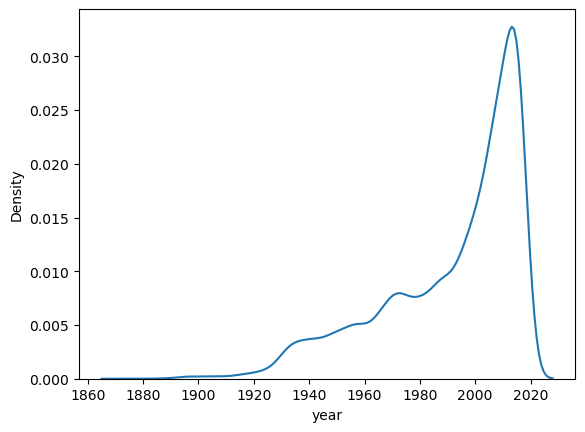

In [ ]:
# density plot for film year
sns.kdeplot(df['year'])
plt.show()

### Correlation results
This correlation table shows the relationship between different movie genres and several movie characteristics such as mean rating, rating count, and year of release. The values in the table represent the Pearson correlation coefficient, which ranges from -1 to 1 and measures the linear association between two variables. Positive values indicate a positive association, meaning that as one variable increases, the other variable also increases. Negative values indicate a negative association, meaning that as one variable increases, the other variable decreases.

Some observations from the table:

There is a positive correlation between the mean rating and rating count of a movie (0.13). This indicates that movies with higher ratings tend to have more ratings.
Film-Noir has a moderate positive correlation with Crime (0.15) and Mystery (0.06). This suggests that movies classified as Film-Noir often have elements of crime and mystery.
Horror movies have a negative correlation with mean rating (-0.22), indicating that they tend to have lower ratings.
Drama movies have a moderate positive correlation with mean rating (0.15) and a moderate positive correlation with Thriller movies (0.24).
There is a negative correlation between year of release and rating count (-0.27), which suggests that older movies tend to have fewer ratings.
In conclusion, this table provides useful information about the relationship between different movie genres and movie characteristics, and can be used to make informed decisions about movie selection and production.


### Covariance results
Covariance is a measure of the linear relationship between two variables. It measures how changes in one variable are associated with changes in the other variable. Covariance is expressed as a numerical value and can range from negative to positive values. A positive covariance means that the two variables are positively related, while a negative covariance means that they are inversely related. A covariance of zero means that there is no linear relationship between the variables.

In the table you've provided, the covariance between two variables can be found in the entries of the matrix. For example, the covariance between "mean_rating" and "Film-Noir" is 0.001774, indicating a very small positive relationship between the two variables. The covariance between "rating_count" and "Crime" is 43.331685, indicating a stronger positive relationship between these two variables.

It's important to keep in mind that covariance only measures linear relationships, so it may not be able to fully capture more complex relationships between variables.

### Dataset Describe
The describe() function applied on the Pandas DataFrame provides statistical information about the features in the DataFrame. According to the results, the mean rating for the movies is 3.110263, with a standard deviation of 0.653225. The minimum and maximum ratings are 0.5 and 5, respectively. The mean count of ratings for each movie is 596.81, with a standard deviation of 2929.96.

The genre columns (Film-Noir, Crime, Mystery, Animation, etc.) are binary, with a mean of either 0 or 0.01 to 0.28. The 25th, 50th, and 75th percentiles for these features are either 0 or close to 0, indicating that the majority of the movies belong to a particular genre. The year_timestamp feature has a mean of 2014.22, with a standard deviation of 4.7. The year feature has a mean of 1991.57 and a standard deviation of 25.09.

/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_2052/3978950111.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_2052/3978950111.py:4: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cov = df.cov()


                mean_rating  rating_count    Horror      IMAX    Action  \
mean_rating        1.000000      0.132640 -0.224045  0.014933 -0.083334   
rating_count       0.132640      1.000000 -0.020006  0.113903  0.106123   
Horror            -0.224045     -0.020006  1.000000 -0.008649 -0.032471   
IMAX               0.014933      0.113903 -0.008649  1.000000  0.080300   
Action            -0.083334      0.106123 -0.032471  0.080300  1.000000   
Musical            0.022940      0.020285 -0.043238  0.012596 -0.047999   
War                0.050338      0.018146 -0.053623 -0.005214  0.064717   
Thriller          -0.073329      0.066996  0.212075  0.006246  0.169424   
Fantasy           -0.018992      0.058577  0.032483  0.066228  0.058225   
Comedy            -0.029512      0.033881 -0.112882 -0.020176 -0.077609   
Romance            0.043127      0.026379 -0.113761 -0.016811 -0.069615   
Animation          0.020720      0.016321 -0.055188  0.043910  0.012667   
Mystery           -0.0122

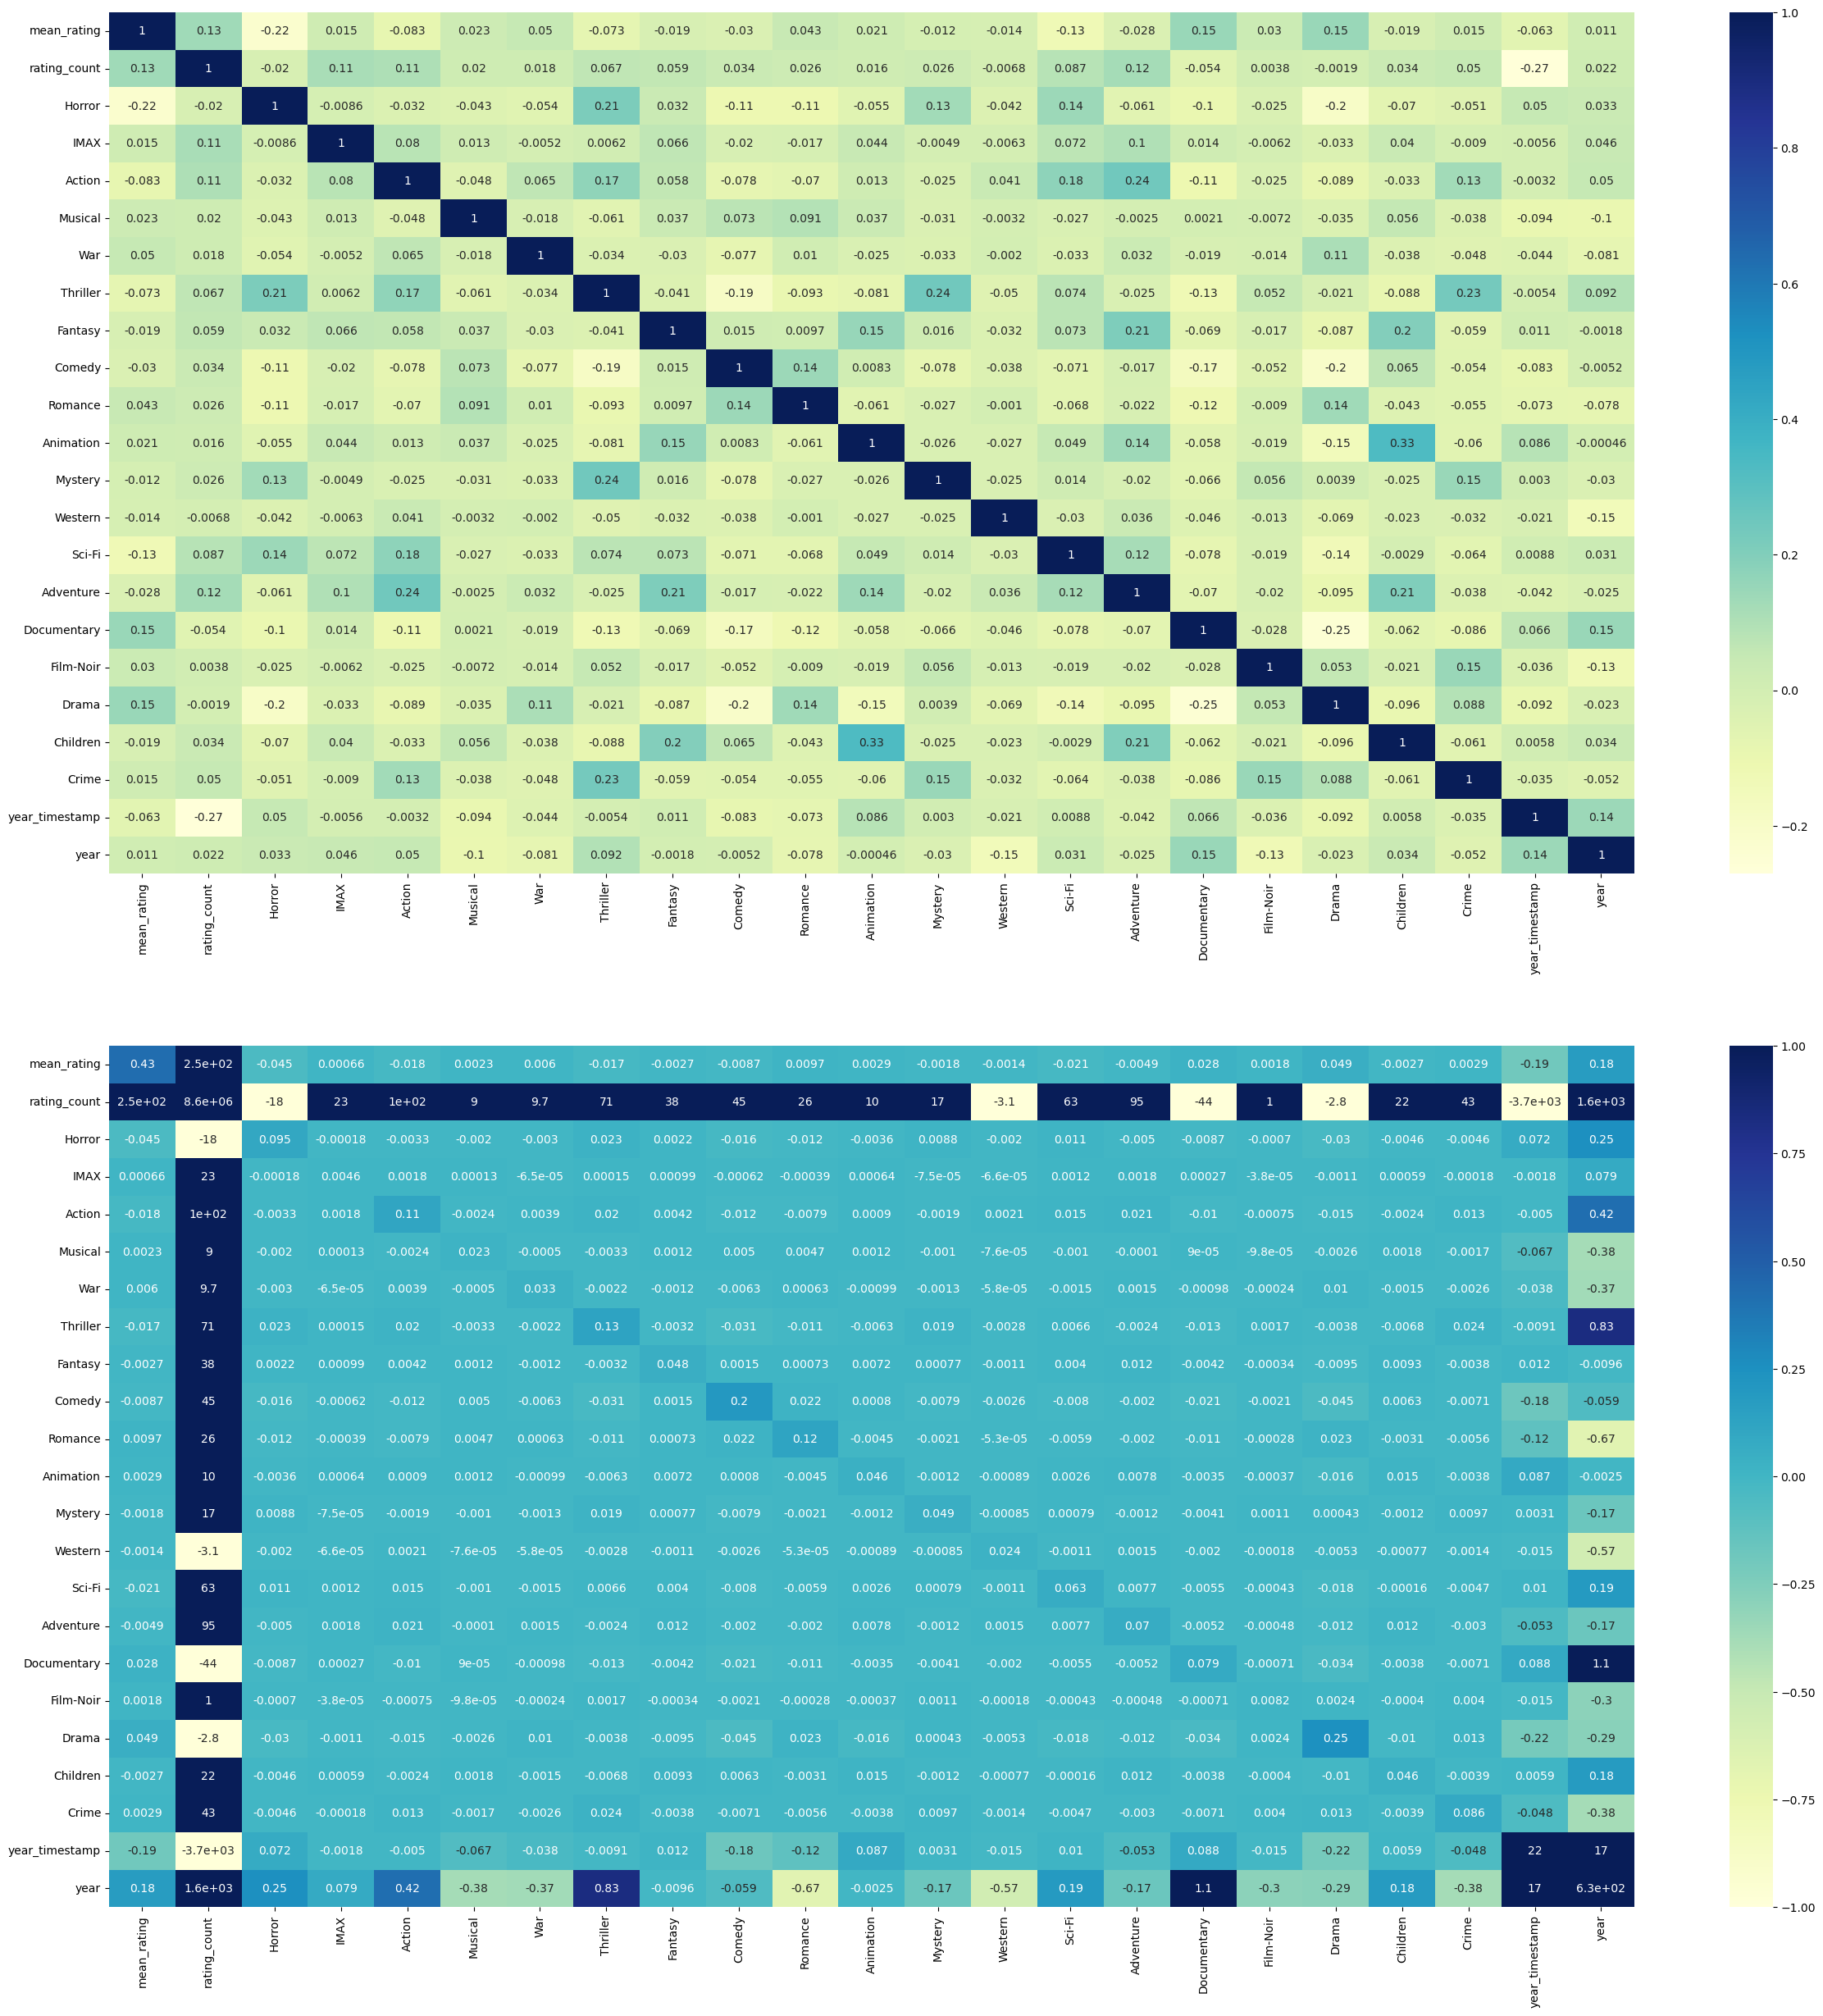

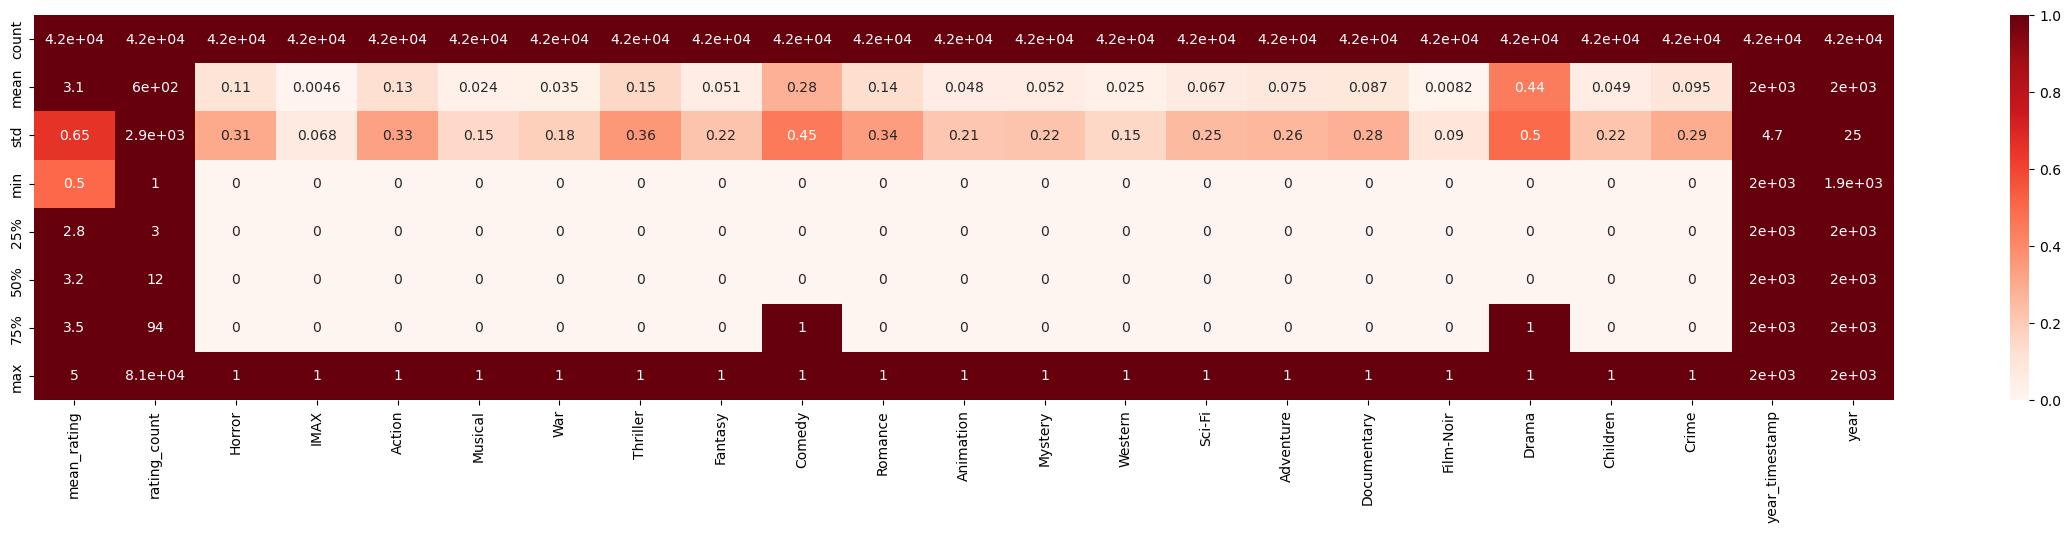

In [ ]:
# compute analysis between attributes of the dataset
corr = df.corr()
print(corr)
cov = df.cov()
print(cov)
desc = df.describe()
print(desc)

# follow examples from slides on Data Visualization (pages 6-8)
fig, axs = plt.subplots(2, 1, figsize=(30, 30))
# show results of correlation in a graphic way
# Plot the heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=axs[0])
# show results of covariance in a graphic way
# Plot the heatmap of the covariance matrix
sns.heatmap(cov, annot=True, cmap="YlGnBu", ax=axs[1], vmax=1, vmin=-1)

plt.show()

# Plot the table
plt.figure(figsize=(30, 5))
sns.heatmap(desc, annot=True, cmap='Reds', vmax=1, vmin=0)
plt.show()


In [ ]:
""" # plot all relationships between attributes
sns.pairplot(df)
plt.show() """

' # plot all relationships between attributes\nsns.pairplot(df)\nplt.show() '

In [ ]:
# remove tag column
df = df.drop(columns=['tag'])

display(df.head())

,mean_rating,rating_count,Horror,IMAX,Action,Musical,War,Thriller,Fantasy,Comedy,...,Western,Sci-Fi,Adventure,Documentary,Film-Noir,Drama,Children,Crime,year_timestamp,year
0,3.893708,57309,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,2006,1995
1,3.251527,24228,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,2005,1995
2,3.142028,11804,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2001,1995
3,2.853547,2523,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1999,1995
4,3.058434,11714,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2001,1995


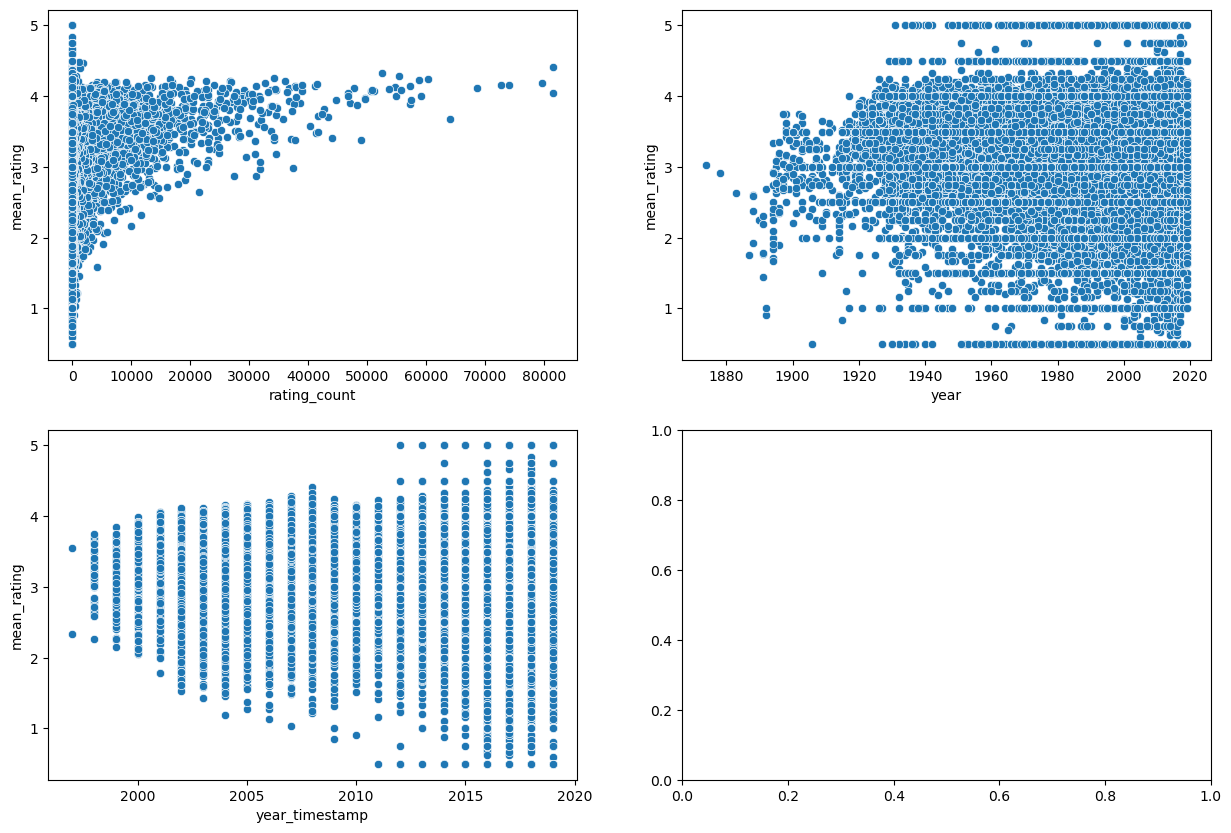

In [ ]:
# show scatter plot for mean_rating-attributes

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x='rating_count', y='mean_rating', data=df, ax=axs[0, 0])
sns.scatterplot(x='year', y='mean_rating', data=df, ax=axs[0, 1])
sns.scatterplot(x='year_timestamp', y='mean_rating', data=df, ax=axs[1, 0])
plt.show()


In [ ]:
# remove rating_count column
df = df.drop(columns=['rating_count'])

display(df.head())

,mean_rating,Horror,IMAX,Action,Musical,War,Thriller,Fantasy,Comedy,Romance,...,Western,Sci-Fi,Adventure,Documentary,Film-Noir,Drama,Children,Crime,year_timestamp,year
0,3.893708,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,2006,1995
1,3.251527,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,2005,1995
2,3.142028,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,2001,1995
3,2.853547,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1999,1995
4,3.058434,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2001,1995


KeyError: '(no genres listed)'

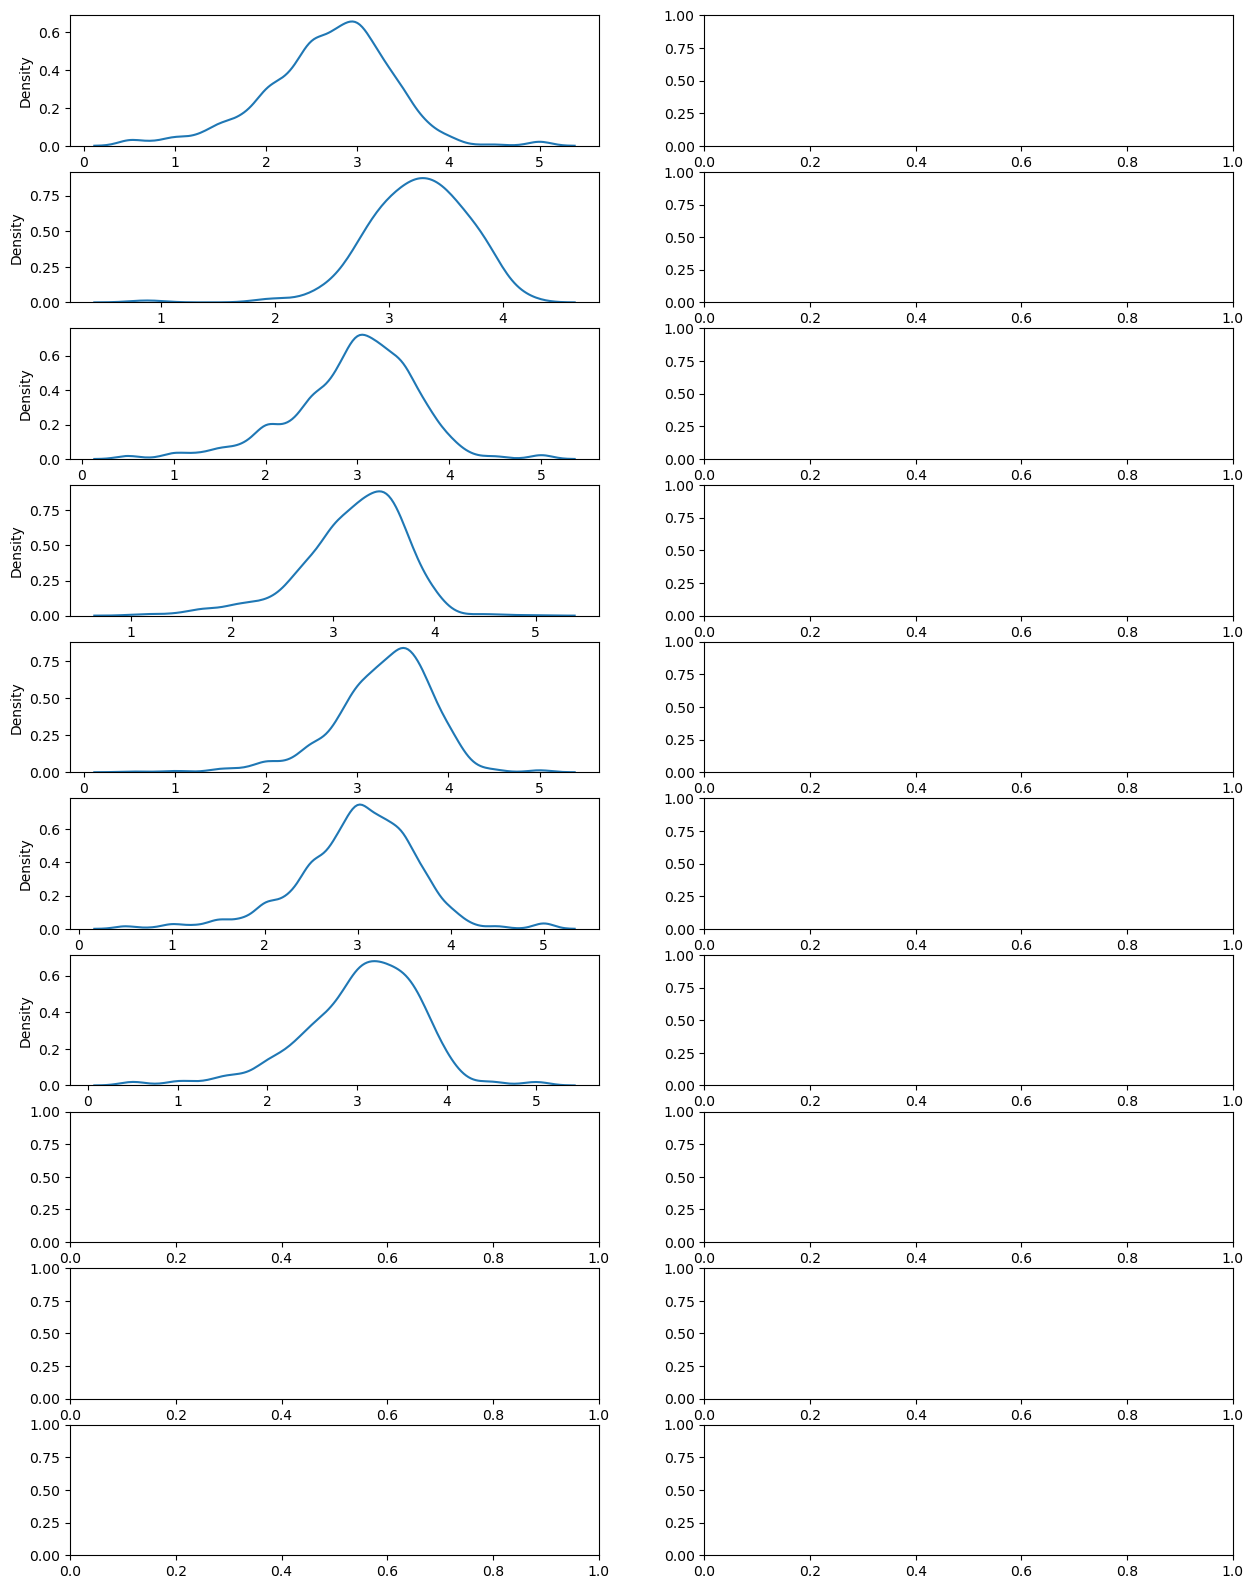

In [ ]:
# show hist plot for mean_rating-genres
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
# create a df with only mean_rating and genres where genres are 1
cat = list(categories)
for category in cat:
    df_genre = df[df[category] == 1]
    if cat.index(category) < 10:
        sns.kdeplot(df_genre['mean_rating'], ax=axs[cat.index(category), 0], label=category)
    else:
        sns.kdeplot(df_genre['mean_rating'], ax=axs[cat.index(category)-10, 1], label=category)

plt.show()


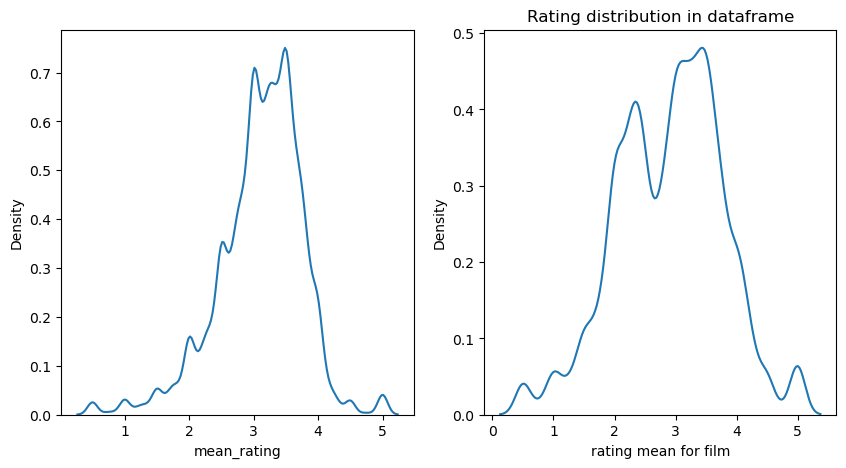

Number of samples in df:  41731
Number of samples in df_preprocessed:  16731


In [ ]:
# balancing dataset
# remove samples_to_drop movies with mean_rating between 2.5 and 4
samples_to_drop = 25000
df_preprocessed = df.copy()
df_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)

# rating distribution from df
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(df['mean_rating'], ax=axs[0])
sns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()

# number of samples in df and df_preprocessed
print('Number of samples in df: ', df.shape[0])
print('Number of samples in df_preprocessed: ', df_preprocessed.shape[0])


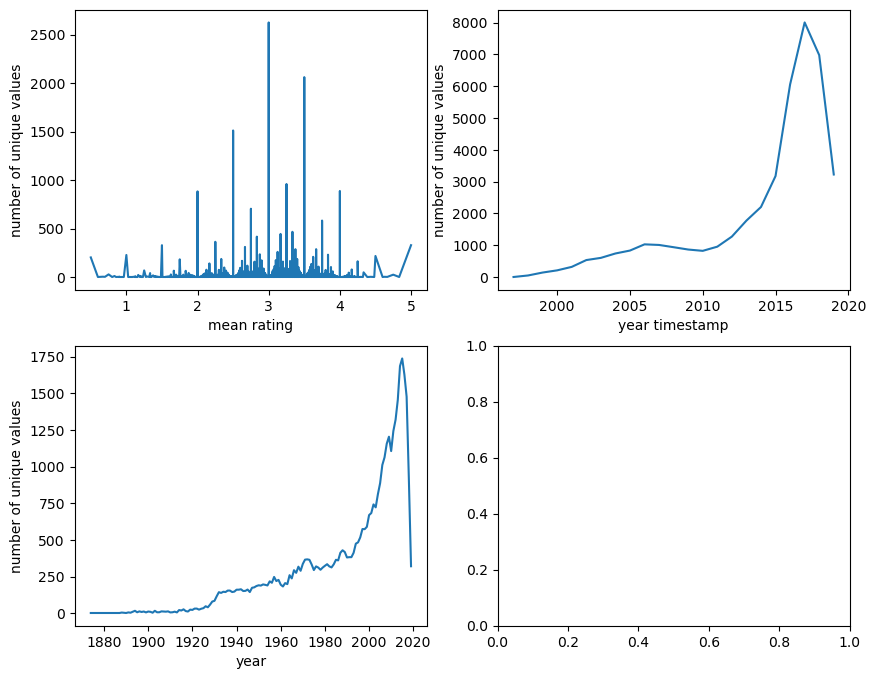

In [ ]:
# Compute the number of unique values for each column
unique_values = {}
for column in df.columns:
    if column == 'mean_rating' or column == 'year_timestamp' or column == 'year':
        unique_values[column] = np.unique(df[column], return_counts=True)

""" # Print the number of unique values for each column
for column in unique_values:
    print(column, ':', unique_values[column]) """

# Plot the number of unique values for each column
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.lineplot(x=unique_values['mean_rating'][0], y=unique_values['mean_rating'][1], ax=axs[0,0])
axs[0,0].set_xlabel('mean rating')
axs[0,0].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['year_timestamp'][0], y=unique_values['year_timestamp'][1], ax=axs[0,1])
axs[0,1].set_xlabel('year timestamp')
axs[0,1].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[1,0])
axs[1,0].set_xlabel('year')
axs[1,0].set_ylabel('number of unique values')
plt.show()


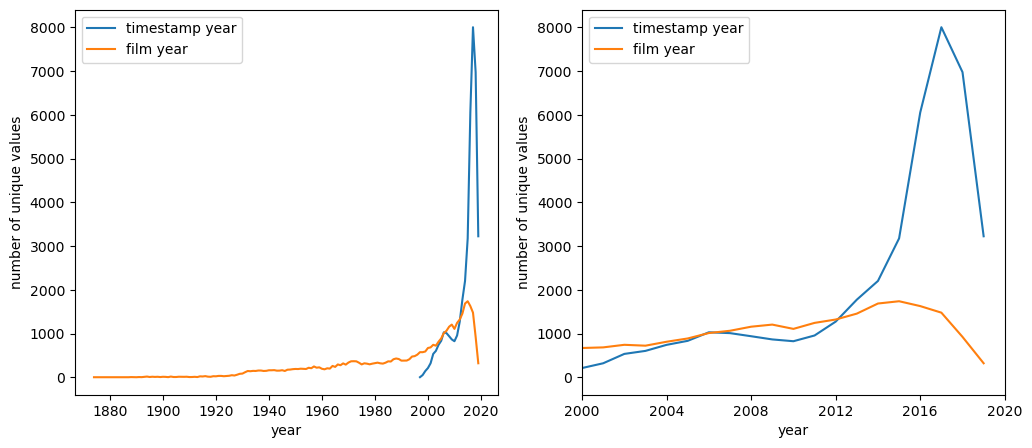

In [ ]:
# show year and year_timestamp in the same plot with values from 2000 to 2020
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.lineplot(x=unique_values['year_timestamp'][0], y=unique_values['year_timestamp'][1], ax=axs[0], label='timestamp year')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[0], label='film year')
axs[0].set_xlabel('year')
axs[0].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['year_timestamp'][0], y=unique_values['year_timestamp'][1], ax=axs[1], label='timestamp year')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[1], label='film year')
axs[1].set_xlabel('year')
axs[1].set_ylabel('number of unique values')
axs[1].set_xlim(2000, 2020)
axs[1].set_xticks(np.arange(2000, 2022, 4))
plt.show()


## Modeling

In [ ]:
# Split data
df_to_use = df.copy()

df2 = df_to_use.copy()
X = df2.drop(columns=['mean_rating'])
y = df_to_use['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import tensorflow as tf

# Create the model using the Keras API of Tensorflow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model, specifying the loss function and optimizer
model.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='adam')

# Train the model on the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)


# Evaluate the model on the test data
loss, mse = model.evaluate(X_test, y_test, verbose=0)
print('Loss: ', loss)
print('MSE: ', mse)

display(y_test[:5])
model.predict(X_test[:5])

2023-02-20 10:50:26.935182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 10:50:40.451757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.9/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series

Epoch 1/100
105/105 [==============================] - 1s 4ms/step - loss: 50.4670 - mean_squared_error: 50.4670 - val_loss: 0.4398 - val_mean_squared_error: 0.4398
Epoch 2/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4311 - mean_squared_error: 0.4311 - val_loss: 0.4245 - val_mean_squared_error: 0.4245
Epoch 3/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4307 - mean_squared_error: 0.4307 - val_loss: 0.4264 - val_mean_squared_error: 0.4264
Epoch 4/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4305 - mean_squared_error: 0.4305 - val_loss: 0.4245 - val_mean_squared_error: 0.4245
Epoch 5/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4303 - mean_squared_error: 0.4303 - val_loss: 0.4246 - val_mean_squared_error: 0.4246
Epoch 6/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4307 - mean_squared_error: 0.4307 - val_loss: 0.4251 - val_mean_squared_error: 0.4251
Epoch 7/100
105/105 

/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_1347/3867802784.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  display(y_test[:5])


36459    2.772727
24390    5.000000
4772     3.015625
20877    1.000000
16731    3.000000
Name: mean_rating, dtype: float64

1/1 [==============================] - 0s 104ms/step


array([[3.319925 ],
       [3.303995 ],
       [3.304178 ],
       [3.278673 ],
       [3.2209222]], dtype=float32)

In [ ]:
""" import torch.nn as nn

# Split data
df2 = df.copy()
X = df2.drop(columns=['mean_rating'])
y = df['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create the model using the torch
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 4),
    nn.ReLU(),
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Compile the model, specifying the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model on the training data X_train and y_train
epochs = 20
for epoch in range(epochs):
    print('Epoch ', epoch)
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate the model on the test data
loss = loss_fn(model(X_test), y_test)
print('Loss: ', loss.item())

display(y_test[:5]) """


" import torch.nn as nn\n\n# Split data\ndf2 = df.copy()\nX = df2.drop(columns=['mean_rating'])\ny = df['mean_rating']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Convert the data to tensors\nX_train = torch.tensor(X_train.values, dtype=torch.float32)\ny_train = torch.tensor(y_train.values, dtype=torch.float32)\nX_test = torch.tensor(X_test.values, dtype=torch.float32)\ny_test = torch.tensor(y_test.values, dtype=torch.float32)\n\n# Create the model using the torch\nmodel = nn.Sequential(\n    nn.Linear(X_train.shape[1], 4),\n    nn.ReLU(),\n    nn.Linear(4, 16),\n    nn.ReLU(),\n    nn.Linear(16, 1)\n)\n\n# Compile the model, specifying the loss function and optimizer\nloss_fn = nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\n\n# Train the model on the training data X_train and y_train\nepochs = 20\nfor epoch in range(epochs):\n    print('Epoch ', epoch)\n    